In [42]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
import tensorflow as tf


In [43]:
def predict_image(image, model):
    category_to_label = {
        0: "Negative",
        1: "Primordial", 
        2: "Primary", 
        3: "Secondary", 
        4: "Tertiary", 
    }

    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    predicted_category, proba = np.argmax(pred),  np.max(pred)
    predicted_label = category_to_label[predicted_category]
    return predicted_label, proba


In [44]:
def display_slice_and_predictions(coupe, predicted_locations):
    linewidth=3
    label_to_color = {
        "Negative": "grey", 
        "Primordial": "blue", 
        "Primary": "red", 
        "Secondary": "green", 
        "Tertiary": "darkgreen"
    }
    
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(coupe)
    ax = plt.gca()
    for prediction in predicted_locations:
        box = prediction["bbox"]
        label = prediction["label"]
        proba = prediction["proba"]

        color = label_to_color[label]
        text = "{}: {:.2f}".format(label, proba)
        linestyle = "-" if proba == 1 else "--"

        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth, linestyle=linestyle
        )
        ax.add_patch(patch)

        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 1},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()

In [110]:
def generate_random_windows_for_image(image, window_size=1000, num_windows=1000):
    """generator of square boxes that create a list of random
    windows for the given image"""
    mean = window_size
    std = 0.15 * window_size
    
    c = 0
    while True:
        width = np.random.normal(mean, std)
        x1 = np.random.randint(0, image.width)
        y1 = np.random.randint(0, image.height)

        bbox = (x1, y1, x1 + width, y1 + width)
        yield bbox
        c += 1
        
        if c > num_windows:
            break

In [72]:

def predict_locations_for_windows(coupe, window_size, model, num_windows=1000):
    boxes = generate_random_windows_for_image(coupe, window_size=window_size, num_windows=num_windows)
    predicted_locations = []
    for box in boxes:
        cropped_image = coupe.crop(box)
        label, proba = predict_image(cropped_image, model)
        predicted_locations.append({
                "bbox": box,
                "label": label,
                "proba": proba
            })
    return predicted_locations

def filter_predictions(predicted_locations, proba_threshold=0.8):
    def should_keep_prediction(label, proba):
        if label == "Negative":
            return False
        if proba < proba_threshold:
            return False
        return True

    selected_locations = [
        prediction
        for prediction in predicted_locations
        if should_keep_prediction(prediction["label"], prediction["proba"])
    ]

    return selected_locations


In [73]:
def load_true_locations(path, image_filename):
    """Return list of {bbox, label, proba}."""
    df = pd.read_csv(path)
    df = df.loc[df["filename"] == image_filename] 
    locations = []
    for _, row in df.iterrows():
        loc_dict = {
            "bbox": (row['xmin'], row['ymin'], row['xmax'], row['ymax']),
            "label": row["class"],
            "proba": 1
        }
        locations.append(loc_dict)
    return locations

In [74]:
this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data")
MODELS_FOLDER = os.path.join(this_folder, "models")

IMAGE_TO_ANALYSE = 'D-1M01-3.jpg'
MODEL_NAME_FOR_PREDICTION = "classifier"


coupe = Image.open(os.path.join(DATA_FOLDER, "coupes_jpg", IMAGE_TO_ANALYSE))
true_locations = load_true_locations(os.path.join(DATA_FOLDER, "scenario1", 'labels.csv'), IMAGE_TO_ANALYSE)
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, MODEL_NAME_FOR_PREDICTION))


## True locations

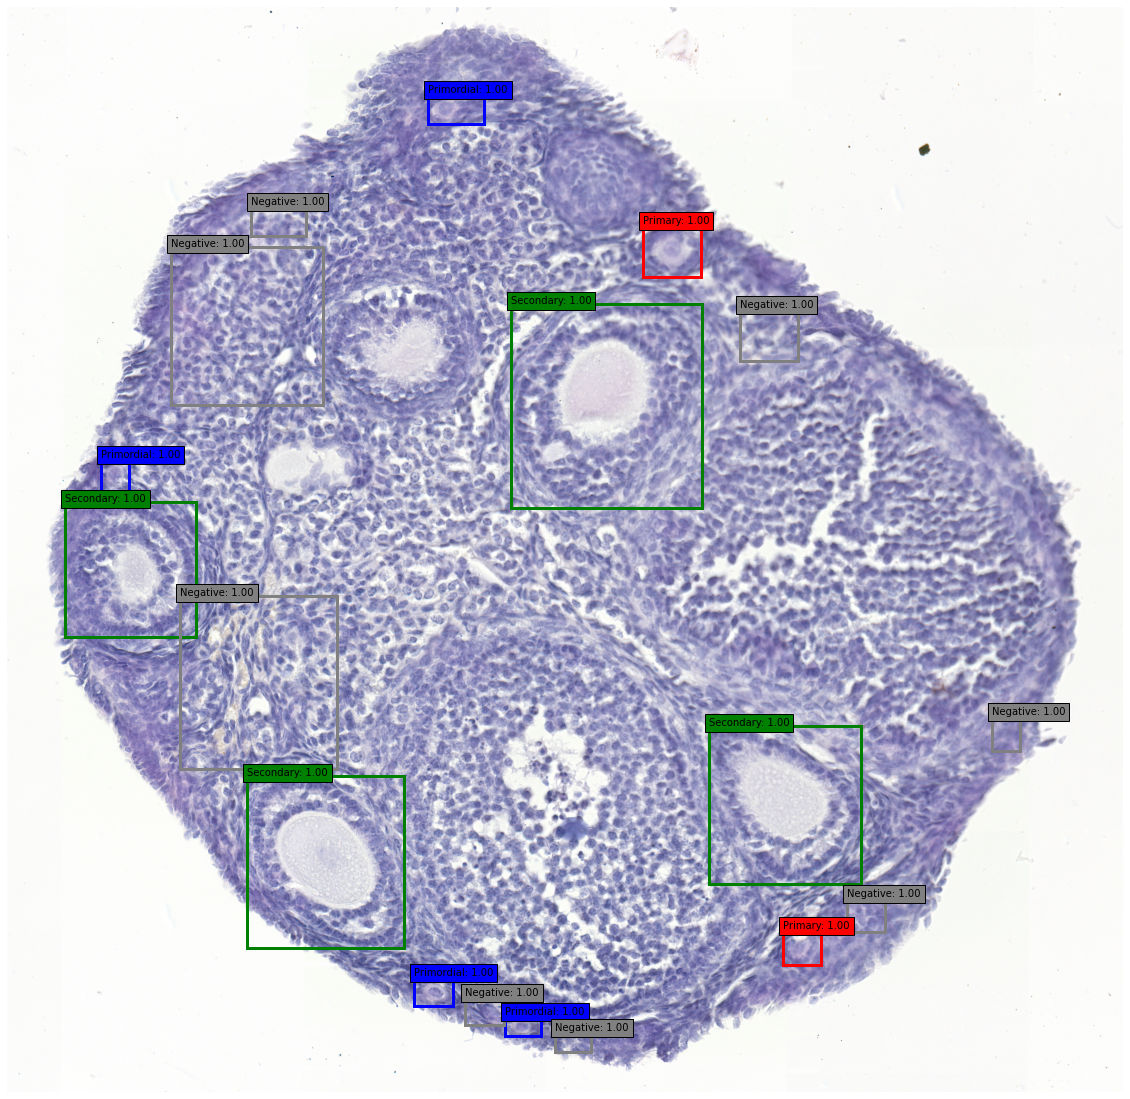

In [49]:
display_slice_and_predictions(coupe, true_locations)

## Predicted locations

In [119]:
predicted_locations = predict_locations_for_windows(coupe, window_size=1000, model=model_loaded, num_windows=2000)

In [112]:
predicted_locations

[{'bbox': (2876, 18, 3068.5946741838466, 210.59467418384662),
  'label': 'Negative',
  'proba': 0.80256605},
 {'bbox': (3250, 3105, 3422.0254904971307, 3277.0254904971307),
  'label': 'Primordial',
  'proba': 0.91485995},
 {'bbox': (3102, 1045, 3262.0302110598336, 1205.0302110598336),
  'label': 'Primordial',
  'proba': 0.78947264},
 {'bbox': (4565, 2486, 4730.907117135977, 2651.907117135977),
  'label': 'Primordial',
  'proba': 0.58124113},
 {'bbox': (2140, 551, 2265.272568038029, 676.272568038029),
  'label': 'Primordial',
  'proba': 0.8332491},
 {'bbox': (1464, 2656, 1629.1967514695152, 2821.196751469515),
  'label': 'Primordial',
  'proba': 0.7017197},
 {'bbox': (1555, 2405, 1702.2479766864597, 2552.24797668646),
  'label': 'Primordial',
  'proba': 0.62015784},
 {'bbox': (1876, 3613, 2003.0223220877547, 3740.0223220877547),
  'label': 'Negative',
  'proba': 0.64028734},
 {'bbox': (1970, 5617, 2122.9804399249524, 5769.980439924952),
  'label': 'Negative',
  'proba': 0.62418854},
 {'

In [113]:
len(predicted_locations)

501

5


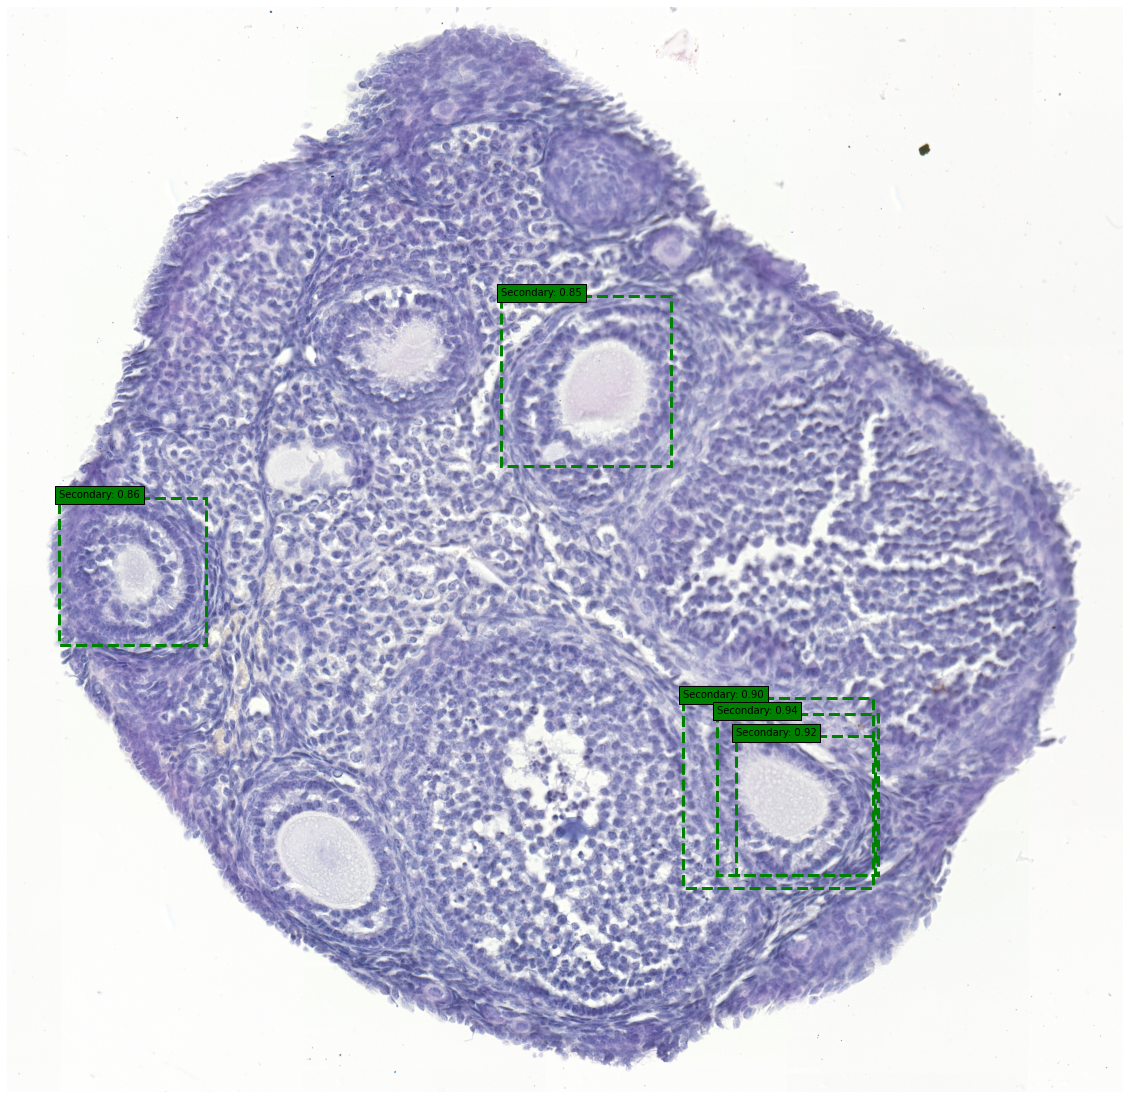

In [120]:
selected_locations = filter_predictions(predicted_locations, proba_threshold=0.85)
print(len(selected_locations))
display_slice_and_predictions(coupe, selected_locations)